** ALZHEIMER’S PREDICTION MODEL - Jonathan Priest **

In [49]:
# imports & setup (1)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
RANDOM_STATE = 42

In [50]:
# Loading dataset (2)
csv_path = "/content/alzheimers_prediction_dataset.csv"

assert os.path.exists(csv_path), f"Not found: {csv_path}"
df = pd.read_csv(csv_path)

print("Rows, Cols:", df.shape)
print(df.head(3))


Rows, Cols: (74283, 25)
        Country  Age  Gender  Education Level   BMI Physical Activity Level  \
0         Spain   90    Male                1  33.0                  Medium   
1     Argentina   72    Male                7  29.9                  Medium   
2  South Africa   86  Female               19  22.9                    High   

  Smoking Status Alcohol Consumption Diabetes Hypertension  ...  \
0          Never        Occasionally       No           No  ...   
1         Former               Never       No           No  ...   
2        Current        Occasionally       No          Yes  ...   

  Dietary Habits Air Pollution Exposure  Employment Status Marital Status  \
0        Healthy                   High            Retired         Single   
1        Healthy                 Medium         Unemployed        Widowed   
2        Average                 Medium           Employed         Single   

  Genetic Risk Factor (APOE-ε4 allele) Social Engagement Level Income Level  \
0 

In [51]:
# Clean/Standardize column names + Define target/feature sets (3)
df2 = df.rename(columns={
    'Alzheimer’s Diagnosis': 'alz_dx',
    'Genetic Risk Factor (APOE-ε4 allele)': 'APOE4',
    'Urban vs Rural Living': 'UrbanRural',
    'Physical Activity Level': 'PhysicalActivity',
    'Family History of Alzheimer’s': 'FamHist'
})

# Target as 0/1
y = df2['alz_dx'].astype(str).str.strip().str.lower().map({'no':0,'yes':1})
if y.isna().any():
    # show unexpected target values if any
    print("Unexpected target values:", df2['alz_dx'].unique())
    raise ValueError("Target mapping produced NaNs.")

X = df2.drop(columns=['alz_dx'])

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['int64','float64']).columns.tolist()

print("num_cols:", num_cols)
print("cat_cols (first 8):", cat_cols[:8])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train/Test:", X_train.shape, X_test.shape,
      "Pos rate:", round(y_train.mean(),3), round(y_test.mean(),3))



num_cols: ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
cat_cols (first 8): ['Country', 'Gender', 'PhysicalActivity', 'Smoking Status', 'Alcohol Consumption', 'Diabetes', 'Hypertension', 'Cholesterol Level']
Train/Test: (59426, 24) (14857, 24) Pos rate: 0.413 0.413


Counts:
 alz_dx
No     43570
Yes    30713
Name: count, dtype: int64

Shares:
 alz_dx
No     0.587
Yes    0.413
Name: count, dtype: float64


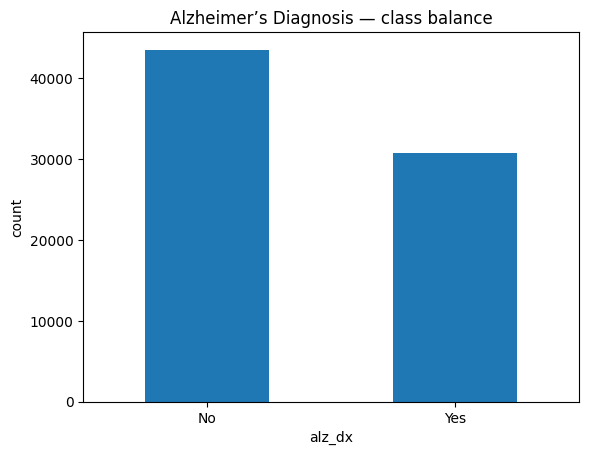

In [52]:
# EDA - Target Balance (4a)
import matplotlib.pyplot as plt

# Counts and shares
target_counts = y.value_counts().rename({0: "No", 1: "Yes"})
print("Counts:\n", target_counts)
print("\nShares:\n", (target_counts / len(y)).round(3))

# Bar plot
ax = target_counts.plot(kind="bar")
plt.title("Alzheimer’s Diagnosis — class balance")
plt.xlabel("alz_dx")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.show()


                        count       mean        std   min   25%   50%   75%  \
Age                   74283.0  71.964703  12.980748  50.0  61.0  72.0  83.0   
Education Level       74283.0   9.487514   5.757020   0.0   4.0   9.0  14.0   
BMI                   74283.0  26.780639   4.764679  18.5  22.7  26.8  30.9   
Cognitive Test Score  74283.0  64.654241  20.153247  30.0  47.0  65.0  82.0   

                       max  
Age                   94.0  
Education Level       19.0  
BMI                   35.0  
Cognitive Test Score  99.0  


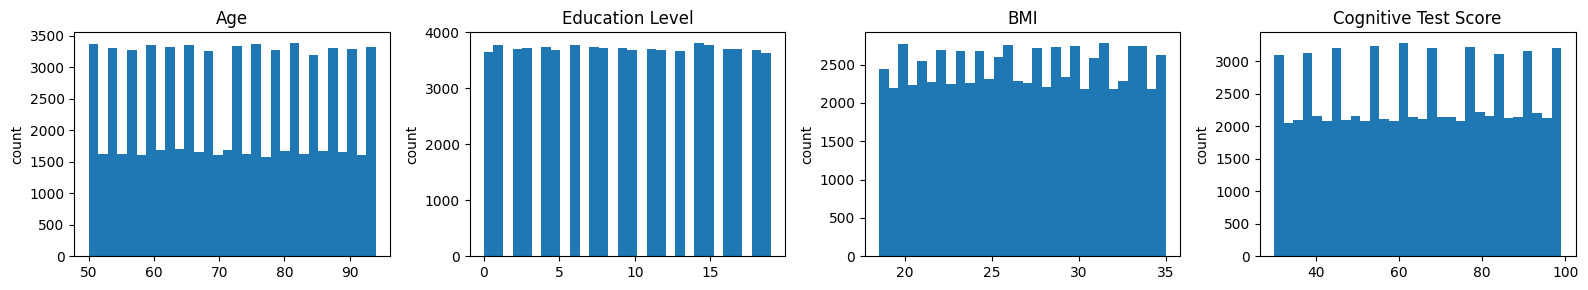

In [53]:
# EDA - Numeric features (4b)
import matplotlib.pyplot as plt

# Summary table
print(df2[num_cols].describe().T)

# Histograms
fig, axes = plt.subplots(1, len(num_cols), figsize=(4 * len(num_cols), 3))
if len(num_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    ax.hist(df2[col], bins=30)
    ax.set_title(col)
    ax.set_ylabel("count")
plt.tight_layout()
plt.show()



Gender counts:
Gender
Female    37249
Male      37034
Name: count, dtype: int64

Gender share:
Gender
Female    0.501
Male      0.499
Name: count, dtype: float64


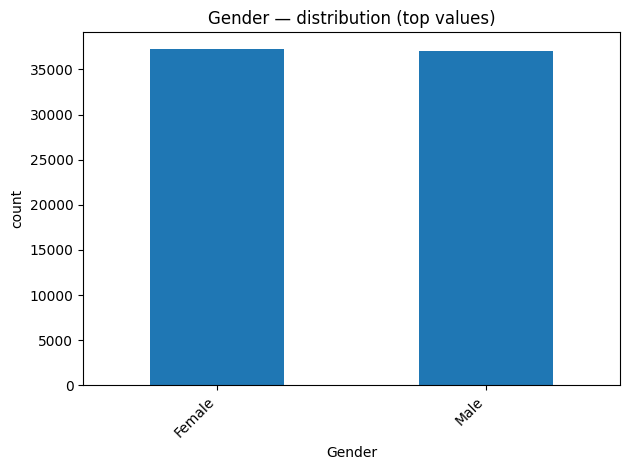


APOE4 counts:
APOE4
No     59561
Yes    14722
Name: count, dtype: int64

APOE4 share:
APOE4
No     0.802
Yes    0.198
Name: count, dtype: float64


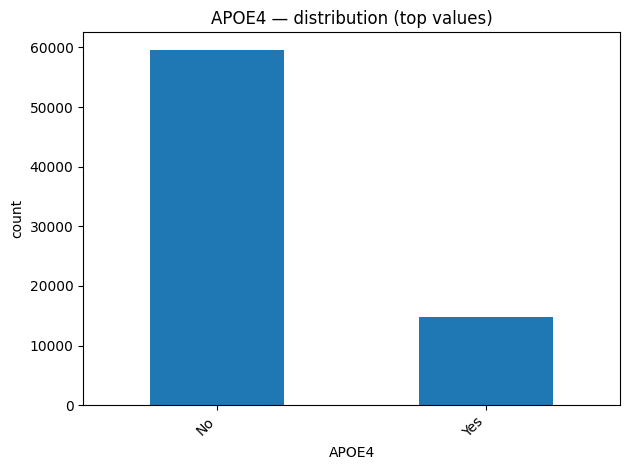


FamHist counts:
FamHist
No     52004
Yes    22279
Name: count, dtype: int64

FamHist share:
FamHist
No     0.7
Yes    0.3
Name: count, dtype: float64


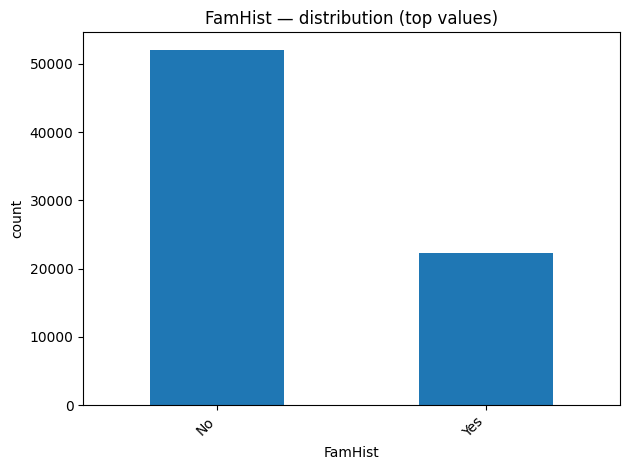


Smoking Status counts:
Smoking Status
Current    24915
Never      24740
Former     24628
Name: count, dtype: int64

Smoking Status share:
Smoking Status
Current    0.335
Never      0.333
Former     0.332
Name: count, dtype: float64


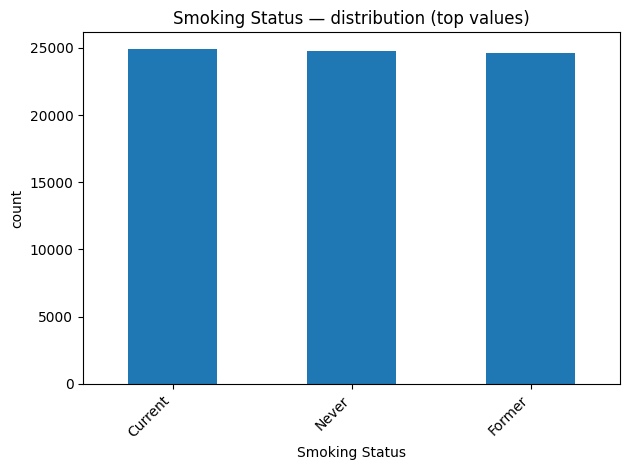


PhysicalActivity counts:
PhysicalActivity
High      24853
Low       24754
Medium    24676
Name: count, dtype: int64

PhysicalActivity share:
PhysicalActivity
High      0.335
Low       0.333
Medium    0.332
Name: count, dtype: float64


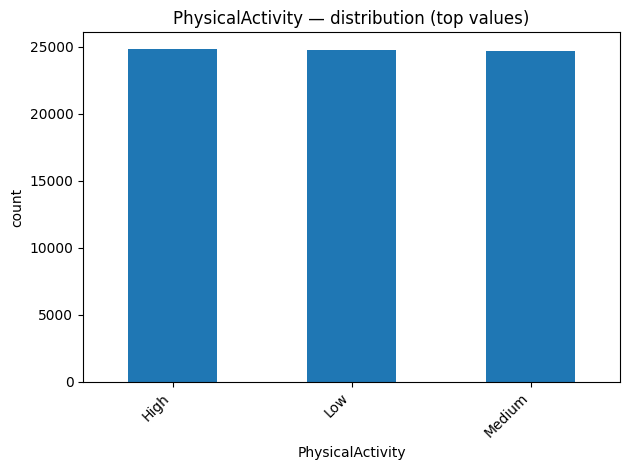


UrbanRural counts:
UrbanRural
Rural    37203
Urban    37080
Name: count, dtype: int64

UrbanRural share:
UrbanRural
Rural    0.501
Urban    0.499
Name: count, dtype: float64


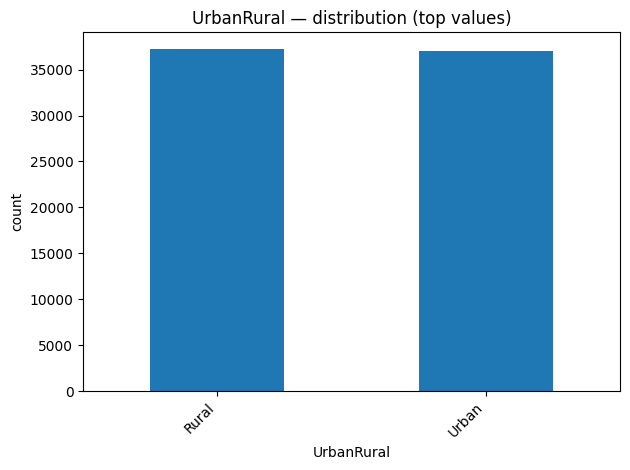


Positive rate by APOE4:
APOE4
Yes    0.606
No     0.366
Name: alz_rate, dtype: float64


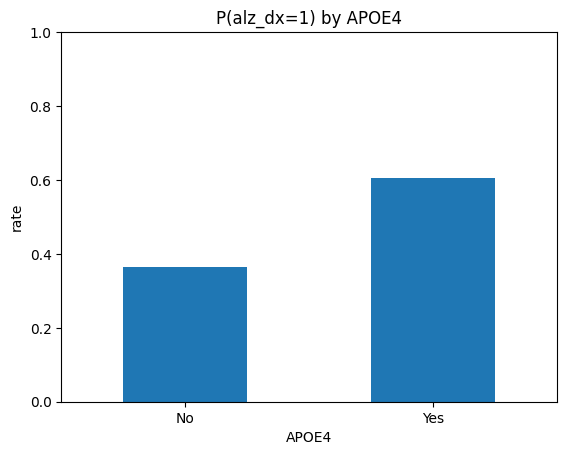


Positive rate by FamHist:
FamHist
Yes    0.519
No     0.368
Name: alz_rate, dtype: float64


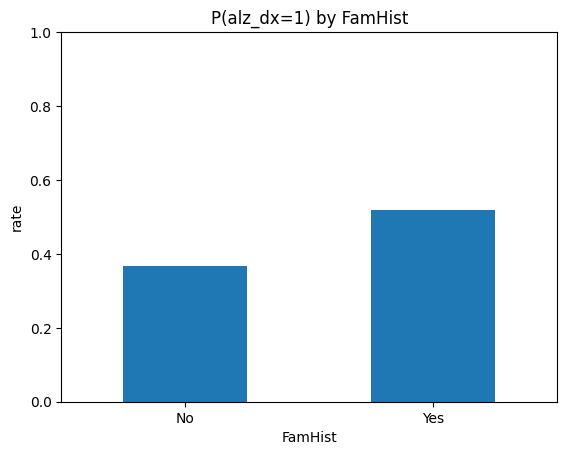


Positive rate by Gender:
Gender
Male      0.414
Female    0.413
Name: alz_rate, dtype: float64


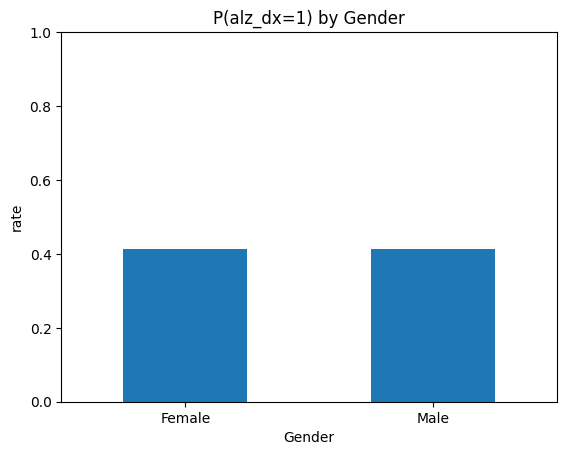

In [54]:
# EDA - Key categorical snapshots (4c)
import matplotlib.pyplot as plt
import pandas as pd

# Pick a handful of important categoricals
cats = ["Gender", "APOE4", "FamHist", "Smoking Status", "PhysicalActivity", "UrbanRural"]

for col in cats:
    vc = df2[col].value_counts(dropna=False)
    print(f"\n{col} counts:\n{vc}")
    print(f"\n{col} share:\n{(vc / len(df2)).round(3)}")

    vc.head(12).plot(kind="bar")
    plt.title(f"{col} — distribution (top values)")
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Outcome rate by a few key categoricals
for col in ["APOE4", "FamHist", "Gender"]:
    rate = pd.crosstab(df2[col], y, normalize="index")[1].rename("alz_rate")
    print(f"\nPositive rate by {col}:\n{rate.sort_values(ascending=False).round(3)}")
    rate.plot(kind="bar")
    plt.title(f"P(alz_dx=1) by {col}")
    plt.ylabel("rate")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.show()


In [55]:
# Preprocess + Logistic Regession (fit) (5)
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

logreg = LogisticRegression(
    max_iter=2000,
    n_jobs=None,
    random_state=42
)

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', logreg)
])

pipe.fit(X_train, y_train)
print("Fitted.")


Fitted.


In [56]:
# Evaluate Logistic Rgression on Test (accuracy, ROC-AUC, confusion matrix, report) (6)
y_pred = pipe.predict(X_test)
if hasattr(pipe.named_steps['clf'], "predict_proba"):
    y_proba = pipe.predict_proba(X_test)[:,1]
else:
    # fallback for models without predict_proba
    from sklearn.metrics import roc_curve
    y_proba = pipe.decision_function(X_test)

acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)
cm   = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC : {auc:.4f}")
print("\nConfusion matrix:\n", cm)
print("\nReport:\n", classification_report(y_test, y_pred, digits=4))



Accuracy: 0.7181
ROC-AUC : 0.7936

Confusion matrix:
 [[6941 1773]
 [2415 3728]]

Report:
               precision    recall  f1-score   support

           0     0.7419    0.7965    0.7682      8714
           1     0.6777    0.6069    0.6403      6143

    accuracy                         0.7181     14857
   macro avg     0.7098    0.7017    0.7043     14857
weighted avg     0.7153    0.7181    0.7153     14857



In [57]:
# Logistic Coefficiants (Feature Importance) (7)
# Get the feature names in the same order as the model sees them
ohe = pipe.named_steps['prep'].named_transformers_['cat']
num_names = [f"num__{c}" for c in num_cols]
cat_names = [f"cat__{n}" for n in ohe.get_feature_names_out(cat_cols)]
feat_names = num_names + cat_names

coefs = pipe.named_steps['clf'].coef_.ravel()
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).drop(columns='abs_coef')

coef_df.head(20)

,feature,coef
0,num__Age,1.060019
62,cat__APOE4_Yes,0.639843
61,cat__APOE4_No,-0.630830
16,cat__Country_Russia,0.536592
11,cat__Country_India,0.479097
6,cat__Country_Brazil,0.454375
18,cat__Country_South Africa,0.431578
42,cat__FamHist_Yes,0.409350
41,cat__FamHist_No,-0.400337
13,cat__Country_Japan,-0.393576


RF Accuracy: 0.7252
RF ROC-AUC: 0.8006

RF Confusion matrix:
 [[6867 1847]
 [2235 3908]]

RF Report:
               precision    recall  f1-score   support

           0     0.7544    0.7880    0.7709      8714
           1     0.6791    0.6362    0.6569      6143

    accuracy                         0.7252     14857
   macro avg     0.7168    0.7121    0.7139     14857
weighted avg     0.7233    0.7252    0.7238     14857



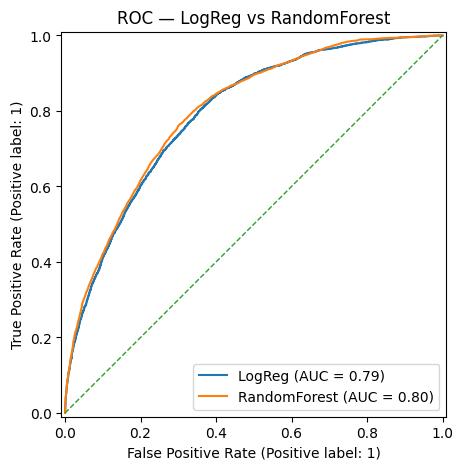

In [58]:
# RandomForest benchmark (fit + evaluate) (8)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Reuse your existing 'preprocess', 'X_train', 'X_test', 'y_train', 'y_test', and LR 'pipe'
rf_pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit & evaluate
rf_pipe.fit(X_train, y_train)
y_pred_rf  = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

print(f"RF Accuracy: {acc_rf:.4f}")
print(f"RF ROC-AUC: {auc_rf:.4f}")
print("\nRF Confusion matrix:\n", cm_rf)
print("\nRF Report:\n", classification_report(y_test, y_pred_rf, digits=4))

# ROC: LR vs RF on one plot
y_proba_lr = pipe.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LogReg", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="RandomForest", ax=ax)
ax.plot([0,1],[0,1],'--',linewidth=1)
ax.set_title("ROC — LogReg vs RandomForest")
plt.show()


In [59]:
# Model Selection Summary (9)
# Build a small comparison table using the metrics we already computed
summary_df = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": acc,
        "ROC_AUC": auc
    },
    {
        "Model": "Random Forest",
        "Accuracy": acc_rf,
        "ROC_AUC": auc_rf
    }
])

summary_df = summary_df.set_index("Model").round(4)
print("Model comparison (test set):")
print(summary_df)

# Choose the "best" model by ROC-AUC (you can mention this in the slides)
if auc_rf >= auc:
    best_model_name = "Random Forest"
    best_pipe = rf_pipe
else:
    best_model_name = "Logistic Regression"
    best_pipe = pipe

print(f"\nBest model by ROC-AUC: {best_model_name}")


Model comparison (test set):
                     Accuracy  ROC_AUC
Model                                 
Logistic Regression    0.7181   0.7936
Random Forest          0.7252   0.8006

Best model by ROC-AUC: Random Forest


In [60]:
# Save best model artifacts (10)
import joblib

# 1. Save the best pipeline (includes preprocessing + model)
model_filename = "alzheimers_best_model.joblib"
joblib.dump(best_pipe, model_filename)

print(f"Saved best model ({best_model_name}) to {model_filename}")

# 2. Save some feature metadata for the Streamlit app
feature_metadata = {
    "feature_columns": X.columns.tolist(),
    "numeric_columns": num_cols,
    "categorical_columns": cat_cols,
    "target_name": "alz_dx",
    "best_model_name": best_model_name,
}

meta_filename = "alz_feature_metadata.joblib"
joblib.dump(feature_metadata, meta_filename)

print(f"Saved feature metadata to {meta_filename}")

Saved best model (Random Forest) to alzheimers_best_model.joblib
Saved feature metadata to alz_feature_metadata.joblib


Average precision (area under PR curve): 0.7256

Sample of precision/recall at different thresholds:
     threshold  precision  recall
0        0.033      0.413   1.000
50       0.200      0.491   0.974
100      0.367      0.606   0.833
150      0.533      0.704   0.555
200      0.700      0.847   0.214
250      0.867      0.941   0.029

Best threshold by F1 score: 0.377
Precision at best threshold: 0.610
Recall at best threshold:    0.825

=== Metrics at threshold 0.500 ===
Accuracy: 0.7254
Confusion matrix:
 [[6809 1905]
 [2175 3968]]
              precision    recall  f1-score   support

           0     0.7579    0.7814    0.7695      8714
           1     0.6756    0.6459    0.6605      6143

    accuracy                         0.7254     14857
   macro avg     0.7168    0.7137    0.7150     14857
weighted avg     0.7239    0.7254    0.7244     14857


=== Metrics at threshold 0.377 ===
Accuracy: 0.71
Confusion matrix:
 [[5478 3236]
 [1073 5070]]
              precision    recall

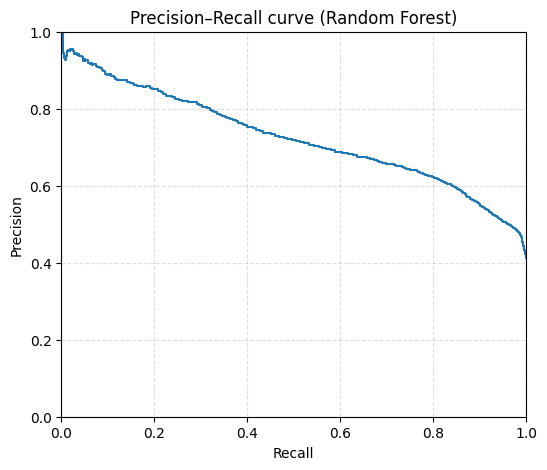

In [61]:
# Threshold tuning & PR curve (11)
from sklearn.metrics import precision_recall_curve, average_precision_score

# Use the best model selected in step 9
y_scores = best_pipe.predict_proba(X_test)[:, 1]

# Precision–recall data
prec, rec, thresh = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

print(f"Average precision (area under PR curve): {ap:.4f}")

# Build a small table of thresholds / precision / recall
# (note: thresh has length = len(prec) - 1)
pr_df = pd.DataFrame({
    "threshold": np.append(thresh, 1.0),
    "precision": prec,
    "recall": rec
})

print("\nSample of precision/recall at different thresholds:")
print(pr_df.iloc[::50].round(3).head(10))  # every ~50th point, just to sample

# Find threshold that maximizes F1
f1_vals = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-8)
best_idx = np.argmax(f1_vals)
best_thresh = thresh[best_idx]

print(f"\nBest threshold by F1 score: {best_thresh:.3f}")
print(f"Precision at best threshold: {prec[best_idx]:.3f}")
print(f"Recall at best threshold:    {rec[best_idx]:.3f}")

# Helper: evaluate metrics at a chosen threshold
def evaluate_at_threshold(th):
    y_pred_custom = (y_scores >= th).astype(int)
    print(f"\n=== Metrics at threshold {th:.3f} ===")
    print("Accuracy:", round(accuracy_score(y_test, y_pred_custom), 4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_custom))
    print(classification_report(y_test, y_pred_custom, digits=4))

# Compare default 0.5 vs tuned threshold
evaluate_at_threshold(0.50)
evaluate_at_threshold(best_thresh)

# Plot the PR curve
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.step(rec, prec, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall curve ({best_model_name})")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [ ]:
# Streamlit app (exportable script) (12)
%%writefile alz_streamlit_app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# Config: file names
# -------------------------------------------------------------------
DATA_CSV   = "alzheimers_prediction_dataset.csv"
MODEL_FILE = "alzheimers_best_model.joblib"
META_FILE  = "alz_feature_metadata.joblib"


# -------------------------------------------------------------------
# Load existing model OR retrain locally if loading fails
# -------------------------------------------------------------------
@st.cache_resource
def load_or_train_model():
    try:
        model = joblib.load(MODEL_FILE)
        meta  = joblib.load(META_FILE)
        return model, meta
    except Exception as e:
        print("Failed to load saved model, retraining locally. Error:", e)

        # 1. Load data
        df = pd.read_csv(DATA_CSV)

        # 2. Clean / rename columns to match the notebook
        df2 = df.rename(columns={
            "Alzheimer’s Diagnosis": "alz_dx",
            "Genetic Risk Factor (APOE-ε4 allele)": "APOE4",
            "Urban vs Rural Living": "UrbanRural",
            "Physical Activity Level": "PhysicalActivity",
            "Family History of Alzheimer’s": "FamHist",
        })

        # 3. Target + features
        y = (
            df2["alz_dx"]
            .astype(str)
            .str.strip()
            .str.lower()
            .map({"no": 0, "yes": 1})
        )
        X = df2.drop(columns=["alz_dx"])

        num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
        cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42, stratify=y
        )

        # 4. Preprocess + RandomForest (your best model)
        preprocess = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), num_cols),
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
            ]
        )

        rf = RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42,
            n_jobs=-1,
        )

        pipe = Pipeline(steps=[
            ("prep", preprocess),
            ("clf", rf),
        ])

        pipe.fit(X_train, y_train)

        # 5. Save new artifacts using THIS sklearn version
        feature_metadata = {
            "feature_columns": X.columns.tolist(),
            "numeric_columns": num_cols,
            "categorical_columns": cat_cols,
            "target_name": "alz_dx",
            "best_model_name": "Random Forest",
        }

        joblib.dump(pipe, MODEL_FILE)
        joblib.dump(feature_metadata, META_FILE)

        return pipe, feature_metadata


# Actually load (or retrain once)
model, meta = load_or_train_model()

feature_cols    = meta["feature_columns"]
num_cols        = meta["numeric_columns"]
cat_cols        = meta["categorical_columns"]
best_model_name = meta["best_model_name"]


# -------------------------------------------------------------------
# Streamlit UI
# -------------------------------------------------------------------
st.set_page_config(page_title="Alzheimer's Prediction Demo", page_icon="🧠")

st.title("Alzheimer's Risk Prediction")
st.markdown(
    "This demo uses a machine-learning model trained on a **74k-row global dataset** "
    "to estimate the probability that a person would receive an Alzheimer's diagnosis "
    "given their demographic, lifestyle, and medical characteristics."
)

st.sidebar.header("Patient profile")

# -------------------------
# Build input dictionary
# -------------------------
inputs = {}

# Numeric features – sliders with sensible ranges
for col in num_cols:
    if col == "Age":
        inputs[col] = st.sidebar.slider("Age (years)", 50, 100, 70)
    elif col == "BMI":
        inputs[col] = st.sidebar.slider("Body Mass Index (BMI)", 15.0, 40.0, 27.0, 0.1)
    elif col == "Education Level":
        inputs[col] = st.sidebar.slider("Education level (years)", 0, 20, 12)
    elif col == "Cognitive Test Score":
        inputs[col] = st.sidebar.slider("Cognitive test score", 0, 100, 65)
    else:
        val = st.sidebar.number_input(col, value=0.0)
        inputs[col] = float(val)

# Key categorical features
inputs["Gender"]           = st.sidebar.selectbox("Gender", ["Male", "Female"])
inputs["APOE4"]            = st.sidebar.selectbox("Genetic risk (APOE-ε4 allele)", ["No", "Yes"])
inputs["FamHist"]          = st.sidebar.selectbox("Family history of Alzheimer's", ["No", "Yes"])
inputs["Smoking Status"]   = st.sidebar.selectbox("Smoking status", ["Never", "Former", "Current"])
inputs["PhysicalActivity"] = st.sidebar.selectbox("Physical activity level", ["Low", "Medium", "High"])
inputs["UrbanRural"]       = st.sidebar.selectbox("Urban vs Rural living", ["Urban", "Rural"])

# Remaining categoricals – reasonable options / defaults
if "Country" in cat_cols:
    inputs["Country"] = st.sidebar.selectbox(
        "Country",
        [
            "USA", "India", "Brazil", "China", "France", "Germany", "Italy", "Spain",
            "Japan", "Mexico", "Canada", "Sweden", "Norway", "South Africa",
            "Russia", "Argentina", "Australia", "UK",
        ],
        index=0,
    )

if "Diabetes" in cat_cols:
    inputs["Diabetes"] = st.sidebar.selectbox("Diabetes", ["No", "Yes"])

if "Hypertension" in cat_cols:
    inputs["Hypertension"] = st.sidebar.selectbox("Hypertension", ["No", "Yes"])

if "Cholesterol Level" in cat_cols:
    inputs["Cholesterol Level"] = st.sidebar.selectbox(
        "Cholesterol level", ["Normal", "Borderline", "High"]
    )

if "Alcohol Consumption" in cat_cols:
    inputs["Alcohol Consumption"] = st.sidebar.selectbox(
        "Alcohol consumption", ["Never", "Occasionally", "Regularly"]
    )

if "Dietary Habits" in cat_cols:
    inputs["Dietary Habits"] = st.sidebar.selectbox(
        "Dietary habits", ["Healthy", "Average", "Unhealthy"]
    )

if "Sleep Quality" in cat_cols:
    inputs["Sleep Quality"] = st.sidebar.selectbox(
        "Sleep quality", ["Poor", "Average", "Good"]
    )

if "Depression Level" in cat_cols:
    inputs["Depression Level"] = st.sidebar.selectbox(
        "Depression level", ["Low", "Moderate", "High"]
    )

if "Social Engagement Level" in cat_cols:
    inputs["Social Engagement Level"] = st.sidebar.selectbox(
        "Social engagement level", ["Low", "Medium", "High"]
    )

if "Income Level" in cat_cols:
    inputs["Income Level"] = st.sidebar.selectbox(
        "Income level", ["Low", "Medium", "High"]
    )

if "Stress Levels" in cat_cols:
    inputs["Stress Levels"] = st.sidebar.selectbox(
        "Stress level", ["Low", "Medium", "High"]
    )

if "Employment Status" in cat_cols:
    inputs["Employment Status"] = st.sidebar.selectbox(
        "Employment status", ["Employed", "Unemployed", "Retired"]
    )

if "Marital Status" in cat_cols:
    inputs["Marital Status"] = st.sidebar.selectbox(
        "Marital status", ["Single", "Married", "Divorced", "Widowed"]
    )

# Fill any missing features with a generic default so schema matches
for col in feature_cols:
    if col not in inputs:
        inputs[col] = "Unknown"

# Turn into DataFrame in correct column order
input_df = pd.DataFrame([inputs])
input_df = input_df[feature_cols]

st.subheader("Current input")
st.dataframe(input_df)

# Threshold slider (ties back to your PR-curve step)
default_threshold = 0.50
thresh = st.slider("Decision threshold", 0.0, 1.0, float(default_threshold), 0.01)

if st.button("Predict Alzheimer's risk"):
    prob = model.predict_proba(input_df)[:, 1][0]
    pred = int(prob >= thresh)

    st.markdown("### Prediction")
    st.write(f"Estimated probability of Alzheimer's diagnosis: **{prob:.2%}**")
    st.write(f"Threshold: **{thresh:.2f}**")
    st.write(f"Predicted class: **{'Yes' if pred == 1 else 'No'}**")

    st.caption(
        f"Underlying model: {best_model_name} pipeline "
        "(StandardScaler + OneHotEncoder + classifier). "
        "On the held-out test set it achieved about **0.80 ROC-AUC**."
    )
